# Analyse og prediksjon av ComfortIndex basert på miljødata

Denne notebooken dokumenterer prosessen med å utvikle en prediktiv modell for å analysere og forutsi miljøforhold uttrykt gjennom **ComfortIndex** – en sammensatt indikator basert på blant annet temperatur, luftfuktighet, solinnstråling, vind og trykk.

Prosjektet henter virkelige miljødata fra åpne kilder, kombinerer disse, og gjennomfører både dataforberedelse, statistisk analyse og maskinlæring for å predikere fremtidige forhold.

---

### Hovedsteg i notebooken:

1. **Datainnhenting og forberedelse**  
   Rensede miljødata lastes inn, med håndtering av manglende verdier og fjerning av irrelevante kolonner.

2. **Feature engineering**  
   Vi lager nye forklaringsvariabler som måned, dag i året og sykliske transformasjoner (`sin`/`cos`) for å fange opp sesongvariasjoner.

3. **Prediktiv modellering**  
   - To **SVR-modeller (Support Vector Regression)** trenes for å forutsi temperatur og solinnstråling ett år frem i tid.
   - En **lineær regresjonsmodell** trenes for å forutsi **ComfortIndex** basert på miljøvariabler.

4. **Train-test-splitt**  
   Datasettet deles i to:  
   - Treningssett brukes for å lære modellen  
   - Testsett brukes for å evaluere ytelsen på usette data  
   Dette er viktig for å unngå overfitting og vurdere hvor godt modellen faktisk generaliserer.

5. **Evaluering av modellens ytelse**  
   Modellens presisjon vurderes med MSE, MAE, MAPE og R².  

6. **Visualiseringer**  
   Resultater presenteres grafisk, inkludert:
   - Faktisk vs. predikert ComfortIndex
   - Residualfordeling
   - Temperatur vs. ComfortIndex med fuktighet som farge
   - Tidsserier for fremtidig temperatur og solinnstråling

---

### Om kategoriske data

Datasettet som brukes i dette prosjektet inneholder kun numeriske variabler, som temperatur, luftfuktighet, trykk og solinnstråling. 
Det er derfor ikke nødvendig med noen form for koding (f.eks. OneHot Encoding eller Label Encoding), siden alle variablene kan brukes direkte i modelltreningen etter standardisering.

Dette forenkler forbehandlingen og gjør at vi kan fokusere på skalering og modellutvikling uten å transformere tekstbaserte kategorier.

---

### Mål
Notebooken viser hvordan vi kan bruke datavitenskap og maskinlæring til å analysere og predikere miljøforhold på en strukturert og etterprøvbar måte, med fokus på reproduserbar kode og tydelig visualisering.



### Importer nødvendige biblioteker

Importerer alle nødvendige pakker og verktøy som brukes for dataanalyse, visualisering og modellering.

In [35]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import timedelta
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
)

sns.set(style="whitegrid")

### Last inn og forbered datasettet

Leser inn det rensede datasettet og forbereder det for videre analyse ved å fjerne unødvendige kolonner, fylle manglende verdier og sortere etter dato.

In [24]:
file_path = Path("../data/clean/merged_data.csv")
df = pd.read_csv(file_path, parse_dates=["Date"])
df.drop(columns=["Unnamed:_0", "Wind_Direction"], inplace=True, errors="ignore")
df.fillna(df.mean(numeric_only=True), inplace=True)
df = df.sort_values("Date")

### Legg til dato-funksjoner (måned, dag i året, sinus og cosinus-transformasjoner)

Lager tidsavhengige egenskaper som brukes i prediktive modeller, inkludert sykliske variabler for å fange sesongvariasjon.

In [25]:
df["Month"] = df["Date"].dt.month
df["DayOfYear"] = df["Date"].dt.dayofyear
df["Sin_Day"] = np.sin(2 * np.pi * df["DayOfYear"] / 365)
df["Cos_Day"] = np.cos(2 * np.pi * df["DayOfYear"] / 365)

### Tren SVR-modeller for temperatur og solinnstråling

Trener to separate Support Vector Regression-modeller for å kunne forutsi fremtidig temperatur og solinnstråling basert på historiske miljødata.
Før modellene trenes, standardiseres dataene med StandardScaler() fra scikit-learn for å sikre at alle inputvariabler har samme skala.
Dette er viktig fordi SVR er en modell som er følsom for verdiskalaer, og ulikheter kan føre til at enkelte variabler dominerer treningsprosessen.
Standardisering transformerer verdiene slik at de har gjennomsnitt 0 og standardavvik 1, og gir dermed en mer balansert modelltrening.


In [26]:
features = [
    "Humidity", "Pressure", "ALLSKY_SFC_SW_DWN", "TS", "QV2M", "PS", "Month", "Sin_Day", "Cos_Day"
]
X = df[features]
y_temp = df["Temperature"]
y_solar = df["ALLSKY_SFC_SW_DWN"]

scaler_X = StandardScaler()
scaler_y_temp = StandardScaler()
scaler_y_solar = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_temp_scaled = scaler_y_temp.fit_transform(y_temp.values.reshape(-1, 1)).flatten()
y_solar_scaled = scaler_y_solar.fit_transform(y_solar.values.reshape(-1, 1)).flatten()

model_temp = SVR(kernel="rbf")
model_solar = SVR(kernel="rbf")
model_temp.fit(X_scaled, y_temp_scaled)
model_solar.fit(X_scaled, y_solar_scaled);

### Lag prediksjoner for ett år frem i tid med SVR-modellen

Bruker de trente modellene til å generere prediksjoner for temperatur og solinnstråling ett år frem i tid, og glatter resultatene med en 7-dagers gjennomsnitt.

In [27]:
num_days = 365
start_date = df["Date"].max()
future_rows = []

for i in range(num_days):
    future_date = start_date + timedelta(days=i + 1)
    month = future_date.month
    day_of_year = future_date.timetuple().tm_yday
    sin_day = np.sin(2 * np.pi * day_of_year / 365)
    cos_day = np.cos(2 * np.pi * day_of_year / 365)

    sample_input = df[df["Month"] == month][features].sample(1).iloc[0].copy()
    sample_input["Month"] = month
    sample_input["Sin_Day"] = sin_day
    sample_input["Cos_Day"] = cos_day

    # Konverter til DataFrame for å unngå advarsler
    scaled_input = scaler_X.transform(pd.DataFrame([sample_input]))
    pred_temp_scaled = model_temp.predict(scaled_input)[0]
    pred_solar_scaled = model_solar.predict(scaled_input)[0]

    pred_temp = scaler_y_temp.inverse_transform([[pred_temp_scaled]])[0, 0]
    pred_solar = scaler_y_solar.inverse_transform([[pred_solar_scaled]])[0, 0]

    future_rows.append({
        "Date": future_date,
        "Pred_Temperature": pred_temp,
        "Pred_Solar": pred_solar
    })

future_df = pd.DataFrame(future_rows)
future_df["Smooth_Temperature"] = future_df["Pred_Temperature"].rolling(window=7, center=True).mean()
future_df["Smooth_Solar"] = future_df["Pred_Solar"].rolling(window=7, center=True).mean()

print("Prediksjoner for neste år er generert og glattet med 7-dagers vindu.")


Prediksjoner for neste år er generert og glattet med 7-dagers vindu.


### Tren og evaluer ComfortIndex-modellen med lineær regresjon

Vi trener en lineær regresjonsmodell for å forutsi **ComfortIndex** basert på flere miljøvariabler som temperatur, luftfuktighet, trykk, vind og solinnstråling. Deretter evaluerer vi modellens ytelse.

Vi bruker fire vanlige regresjonsmål for å vurdere nøyaktigheten:

- **MSE (Mean Squared Error)**: Gjennomsnittlig kvadrert feil. Lav verdi tyder på høy presisjon.
- **MAE (Mean Absolute Error)**: Gjennomsnittlig absolutt feil. Gir en lett forståelig feil i samme skala som ComfortIndex.
- **MAPE (Mean Absolute Percentage Error)**: Prosentvis feil. Kan bli ekstremt høy hvis ComfortIndex inneholder null eller svært små verdier.
- **R² (Forklaringsgrad)**: Forteller hvor stor andel av variasjonen i ComfortIndex modellen forklarer. Verdi nær 1 indikerer svært god forklaringskraft.

Merk: MAPE gir i dette tilfellet en ekstremt høy verdi og er derfor lite meningsfull. Dette skjer når enkelte målverdier er nær null, og tyder ikke nødvendigvis på at modellen er dårlig.

In [34]:
comfort_features = [
    "Temperature", "Wind_Speed", "Humidity", "Pressure",
    "ALLSKY_SFC_SW_DWN", "TS", "QV2M", "PS"
]
X_comfort = df[comfort_features]
y_comfort = df["ComfortIndex"]
X_train, X_test, y_train, y_test = train_test_split(X_comfort, y_comfort, test_size=0.2, random_state=42)

comfort_model = LinearRegression()
comfort_model.fit(X_train, y_train)
y_pred = comfort_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("ComfortIndex-modellens ytelse:")
print(f" - MSE:  {mse:.2f}")
print(f" - MAE:  {mae:.2f}")
print(f" - MAPE: {mape:.2%}")
print(f" - R²:   {r2:.2f}")

ComfortIndex-modellens ytelse:
 - MSE:  0.32
 - MAE:  0.43
 - MAPE: 299376975717534.06%
 - R²:   0.99


### Visualisering: Faktisk vs. predikert ComfortIndex

Dette scatterplottet viser forholdet mellom de faktiske og de predikerte verdiene av ComfortIndex.
Et ideelt resultat vil plassere alle punktene langs diagonalen y = x.
Visualiseringen hjelper oss å vurdere hvor nøyaktig modellen er – avvik fra linjen tyder på under- eller overprediksjon.
Vi bruker sns.scatterplot() for å plotte punktene og plt.plot() for å tegne referanselinjen.

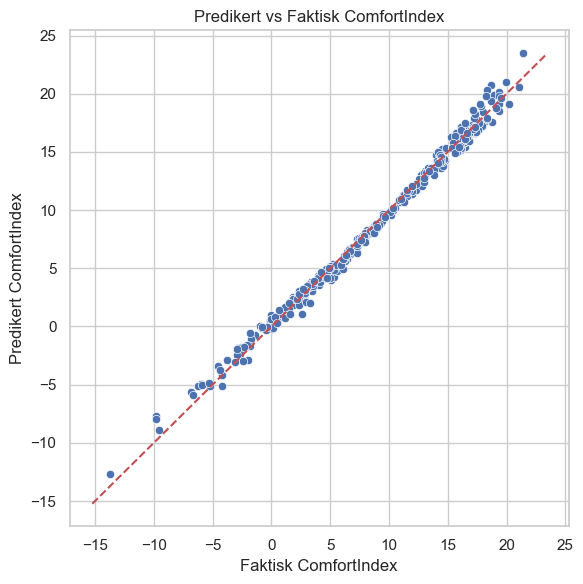

In [11]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_comfort.min(), y_comfort.max()], [y_comfort.min(), y_comfort.max()], "r--")
plt.xlabel("Faktisk ComfortIndex")
plt.ylabel("Predikert ComfortIndex")
plt.title("Predikert vs Faktisk ComfortIndex")
plt.tight_layout()
plt.show()

### Visualisering: Fordeling av residualer

Dette histogrammet viser fordelingen av residualer – forskjellen mellom faktiske og predikerte verdier.
Visualiseringen hjelper med å identifisere skjevhet eller systematiske feil i modellen.
Et symmetrisk histogram rundt 0 tyder på at modellen er balansert og ikke systematisk feilaktig.
Vi bruker sns.histplot() med kde=True for å vise både stolpediagram og sannsynlighetskurve.

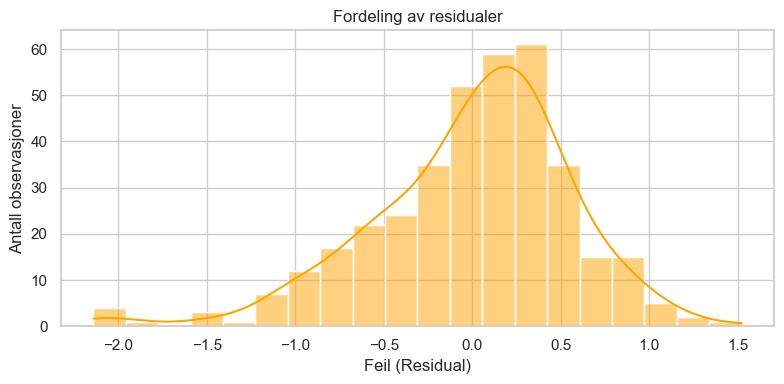

In [12]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=20, color="orange")
plt.title("Fordeling av residualer")
plt.xlabel("Feil (Residual)")
plt.ylabel("Antall observasjoner")
plt.tight_layout()
plt.show()

### Visualisering: Temperatur vs ComfortIndex med fuktighet som farge

Dette scatterplottet viser hvordan ComfortIndex varierer med temperatur, med fargeskala basert på luftfuktighet.
Denne visualiseringen hjelper oss å oppdage mønstre og samspill mellom variabler, som ikke nødvendigvis er lineære.
Ved å bruke c=df["Humidity"] i plt.scatter() og kombinere med plt.colorbar(), får vi frem hvordan fuktighet påvirker sammenhengen mellom temperatur og ComfortIndex.



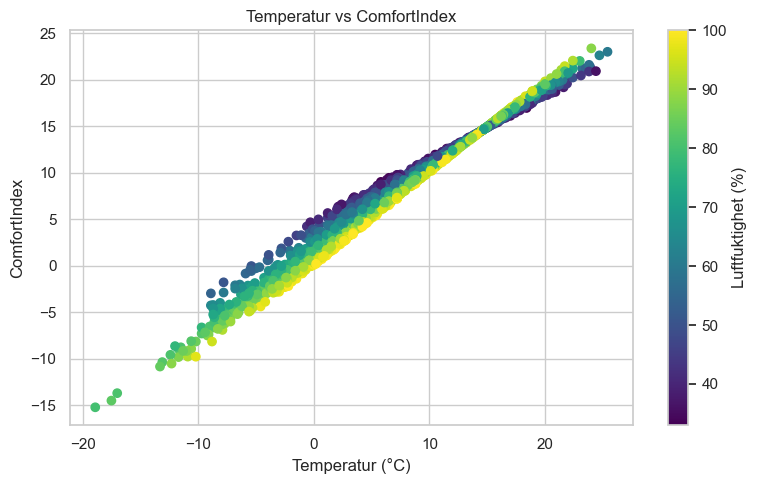

In [13]:
plt.figure(figsize=(8, 5))
scatter = plt.scatter(df["Temperature"], df["ComfortIndex"], c=df["Humidity"], cmap="viridis")
cbar = plt.colorbar(scatter)
cbar.set_label("Luftfuktighet (%)")
plt.title("Temperatur vs ComfortIndex")
plt.xlabel("Temperatur (°C)")
plt.ylabel("ComfortIndex")
plt.tight_layout()
plt.show()

### Visualisering: SVR-prediksjon av temperatur frem i tid

Denne linjegrafen viser predikert temperatur for ett år fremover, glattet med 7-dagers rullende gjennomsnitt.
Dette hjelper oss å forstå sesongmønstre og identifisere trender og svingninger over tid.
Vi bruker plt.plot() og setter linestyle="--" for å fremheve den glatte kurven.

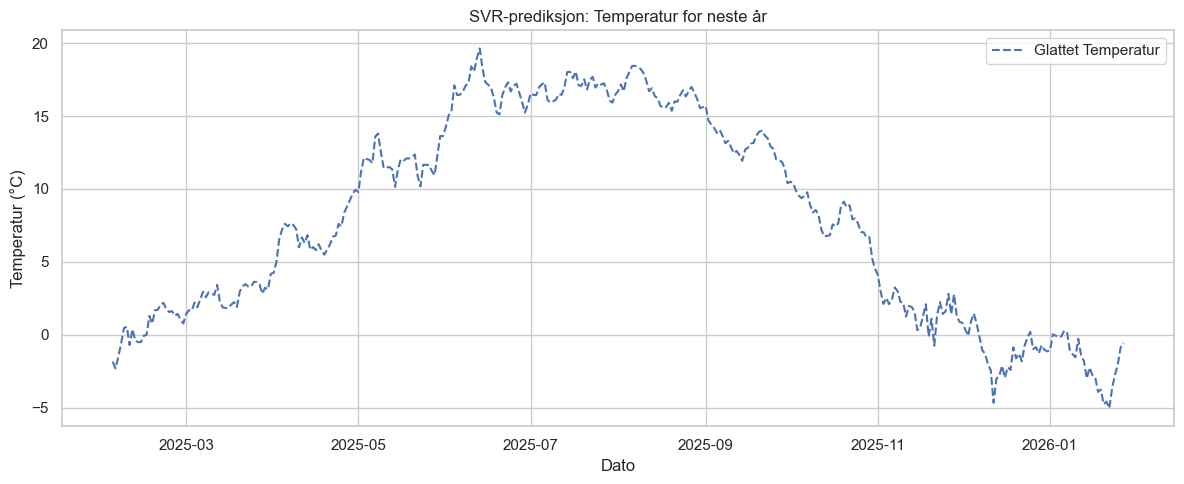

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(future_df["Date"], future_df["Smooth_Temperature"], label="Glattet Temperatur", linestyle="--")
plt.title("SVR-prediksjon: Temperatur for neste år")
plt.xlabel("Dato")
plt.ylabel("Temperatur (°C)")
plt.legend()
plt.tight_layout()
plt.show()

### Visualisering: SVR-prediksjon av solinnstråling frem i tid

Denne figuren viser predikert solinnstråling (ALLSKY_SFC_SW_DWN) for det kommende året.
Som med temperatur benytter vi 7-dagers glatting for å få frem overordnede trender og sesongvariasjon.
plt.plot() brukes til å vise verdiene som en jevn kurve, og plt.legend() samt plt.tight_layout() sørger for lesbar og ryddig presentasjon.

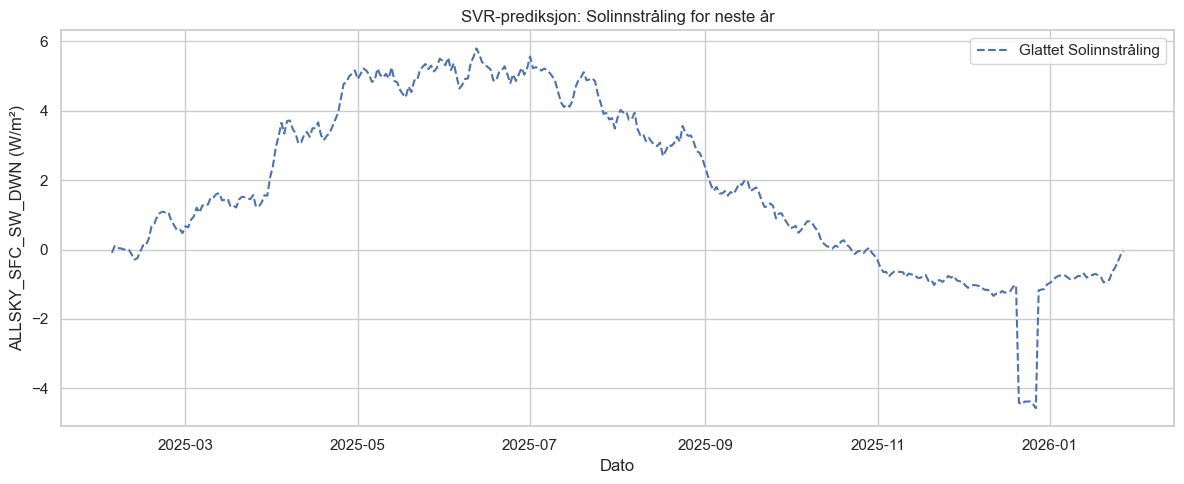

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(future_df["Date"], future_df["Smooth_Solar"], label="Glattet Solinnstråling", linestyle="--")
plt.title("SVR-prediksjon: Solinnstråling for neste år")
plt.xlabel("Dato")
plt.ylabel("ALLSKY_SFC_SW_DWN (W/m²)")
plt.legend()
plt.tight_layout()
plt.show()